## **Dependencias**

In [659]:
%pip install -q agentpy numpy matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## **Imports y estilo**

In [660]:
import agentpy as ap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
sns.set(context="notebook", style="whitegrid")

## **Parámetros**

In [661]:
def get_traffic_scenario(scenario='low'):
    scenarios = {
        'low': {
            'lambda_N': 0.10, 'lambda_S': 0.11,
            'lambda_E': 0.08, 'lambda_W': 0.08,
            'description': 'Light balanced traffic'
        },
        'med': {
            'lambda_N': 0.35, 'lambda_S': 0.31,  # Heavy N-S traffic
            'lambda_E': 0.15, 'lambda_W': 0.18,  # Moderate E-W traffic
            'description': 'Rush hour with dominant N-S flow'
        },
        'high': {
            'lambda_N': 0.40, 'lambda_S': 0.39,  # Uneven N-S (into city)
            'lambda_E': 0.13, 'lambda_W': 0.16,  # Uneven E-W
            'description': 'Morning commute pattern'
        }
    }
    return scenarios[scenario]

# Select scenario here - try different ones!
traffic_scenario = get_traffic_scenario('high')  # Change this to test different scenarios

In [662]:
params = {
    'steps': 2500,          # duración en ticks (1 tick = 1 s)
    'green_ns': 25,        # VERDE para Norte-Sur
    'green_ew': 25,        # VERDE para Este-Oeste
    'yellow': 3,           # ÁMBAR
    'all_red': 1,          # ALL-RED (despeje)
    # Traffic scenario rates
    **traffic_scenario,    # This unpacks the lambda values from the scenario
    # Cinemática
    'v_free': 7.0,         # m/s
    'headway': 8.0,        # m separación mínima
    # Geometría (intersección centrada en 0,0)
    'L': 80.0,             # media-calzada (desde centro al extremo de dibujo)
    'w': 3.5,              # ancho de carril
    # Q-learning parameters
    'use_qlearning': True,  # Enable/disable Q-learning
    'alpha': 0.15,         # Learning rate
    'gamma': 0.90,         # Discount factor
    'epsilon': 0.3,        # Exploration rate
    'epsilon_decay': 0.995, # Decay rate for epsilon
    'min_epsilon': 0.05,   # Minimum exploration rate
    'state_update_freq': 5, # How often to update Q-learning (every N steps)
}

In [663]:
def lights_from_phase_sub(phase, sub):
    """Helper function to get lights configuration from phase and sub-state"""
    L = {d:'R' for d in ['N','S','E','W']}
    if phase == 0:
        L['N'] = L['S'] = sub
    else:
        L['E'] = L['W'] = sub
    return L

In [ ]:
class QLearningController:
    """Q-learning agent for traffic light control"""
    
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1, epsilon_decay=0.999, min_epsilon=0.01):
        self.alpha = alpha              # Learning rate
        self.gamma = gamma              # Discount factor
        self.epsilon = epsilon          # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Q-table: state -> action -> Q-value
        self.Q = defaultdict(lambda: defaultdict(float))
        
        # State-action history for learning
        self.last_state = None
        self.last_action = None
        
        # Performance tracking
        self.total_reward = 0
        self.episode_rewards = []
        
    def get_state(self, model):
        """Convert current traffic conditions to state representation"""
        # Count cars waiting at each approach with distance consideration
        waiting_cars = {'N': 0, 'S': 0, 'E': 0, 'W': 0}
        approaching_cars = {'N': 0, 'S': 0, 'E': 0, 'W': 0}
        
        for car in model.cars:
            if car.state == 'stop':
                waiting_cars[car.origin] += 1
            elif car.state == 'approach' and car.dist_to(car.stopline) < 25:
                approaching_cars[car.origin] += 1
        
        # More granular discretization to better represent queue states
        def discretize_count(count):
            if count == 0: return 0
            elif count <= 1: return 1
            elif count <= 3: return 2
            elif count <= 6: return 3
            elif count <= 10: return 4
            else: return 5  # Very high queue
        
        # Include time in current phase to prevent getting stuck
        time_in_phase = min(model.ctrl.t_in, 30) // 5  # Discretize time (0-6 levels)
        
        # Create state tuple with better representation
        state = (
            discretize_count(waiting_cars['N'] + waiting_cars['S']),  # NS waiting
            discretize_count(waiting_cars['E'] + waiting_cars['W']),  # EW waiting
            discretize_count(approaching_cars['N'] + approaching_cars['S']),  # NS approaching  
            discretize_count(approaching_cars['E'] + approaching_cars['W']),  # EW approaching
            model.ctrl.phase,  # Current phase (0=NS, 1=EW)
            0 if model.ctrl.sub == 'G' else 1,  # Green=0, Yellow/AllRed=1
            time_in_phase  # Time spent in current phase
        )
        return state
    
    def get_actions(self):
        """Available actions: 0=continue current phase, 1=switch to next phase"""
        return [0, 1]
    
    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.get_actions())
        else:
            q_values = [self.Q[state][a] for a in self.get_actions()]
            return self.get_actions()[np.argmax(q_values)]
    
    def calculate_reward(self, model):
        # Count waiting cars by direction
        waiting_ns = len([c for c in model.cars if c.state == 'stop' and c.origin in ['N', 'S']])
        waiting_ew = len([c for c in model.cars if c.state == 'stop' and c.origin in ['E', 'W']])
        
        # Static penalty for cars waiting more than 10 seconds
        starvation_penalty = len([c for c in model.cars if c.state == 'stop' and c.wait_time > 30]) * -3.5
        # Additional starvation penalty for cars waiting more than 7 seconds
        starvation_penalty_early = len([c for c in model.cars if c.state == 'stop' and c.wait_time > 15]) * -2.0
        
        # Penalty for queue imbalance to prevent favoring one direction
        queue_imbalance = abs(waiting_ns - waiting_ew)
        imbalance_penalty = queue_imbalance * -0.5 + 5
        
        # Base penalty for total number of waiting cars (encourages throughput)
        queue_penalty = -(waiting_ns + waiting_ew)
        
        # Reward for serving traffic (throughput)
        current_green = model.ctrl.green_dirs
        throughput_reward = 0
        if current_green:
            cars_served = len([c for c in model.cars if c.state == 'go' and c.origin in current_green])
            throughput_reward = cars_served * 0.30
        
        # Penalty for being in green phase too long (prevents getting stuck)
        if model.ctrl.sub == 'G' and model.ctrl.t_in > 35:
            time_penalty = (model.ctrl.t_in - 35) * -0.5
        else:
            time_penalty = 0
        
        # Combined reward - simple and fair
        reward = queue_penalty + starvation_penalty + starvation_penalty_early +imbalance_penalty + throughput_reward + time_penalty
        
        return reward
    
    def update_q_value(self, state, action, reward, next_state):
        """Q-learning update rule"""
        if next_state is not None:
            max_next_q = max([self.Q[next_state][a] for a in self.get_actions()])
            self.Q[state][action] += self.alpha * (
                reward + self.gamma * max_next_q - self.Q[state][action]
            )
        else:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

## **Controlador de semáforos**

In [665]:
class EnhancedFourWaySignals(ap.Agent):
    """Enhanced controller that can work in both fixed and Q-learning modes"""

    def setup(self, green_ns, green_ew, yellow, all_red, use_qlearning=False):
        self.g_ns, self.g_ew = int(green_ns), int(green_ew)
        self.y, self.ar = int(yellow), int(all_red)
        self.phase = 0          # 0 = NS verde, 1 = EW verde
        self.sub = 'G'          # 'G','Y','AR'
        self.t_in = 0
        self.timeline = []      # [(t, {'N':R/Y/G, 'S':..., 'E':..., 'W':...})]
        
        # Q-learning integration
        self.use_qlearning = use_qlearning
        if use_qlearning:
            self.qlearning = QLearningController(
                alpha=self.model.p.alpha,
                gamma=self.model.p.gamma,
                epsilon=self.model.p.epsilon,
                epsilon_decay=self.model.p.epsilon_decay,
                min_epsilon=self.model.p.min_epsilon
            )
            self.phase_switch_requested = False
        
        # For tracking controller type in analysis
        self.controller_type = "Q-Learning" if use_qlearning else "Fixed-Time"

    def lights(self):
        return lights_from_phase_sub(self.phase, self.sub)

    @property
    def green_dirs(self):
        if self.sub != 'G': return set()
        return {'N','S'} if self.phase == 0 else {'E','W'}

    def step(self):
        self.timeline.append((self.model.t, self.lights()))
        
        if self.use_qlearning:
            self._step_qlearning()
        else:
            self._step_fixed()
    
    def _step_fixed(self):
        """Fixed-time controller logic"""
        if self.phase == 0:  # NS phase
            if self.sub == 'G' and self.t_in >= self.g_ns:
                self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y:
                self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar:
                self.phase, self.sub, self.t_in = 1, 'G', 0
            else:
                self.t_in += 1
        else:  # EW phase
            if self.sub == 'G' and self.t_in >= self.g_ew:
                self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y:
                self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar:
                self.phase, self.sub, self.t_in = 0, 'G', 0
            else:
                self.t_in += 1
    
    def _step_qlearning(self):
        """Q-learning controller logic (existing implementation)"""
        # Always compute current_state if Q-learning is enabled
        current_state = self.qlearning.get_state(self.model)
        
        # Q-learning decision making (only during green phase and at update intervals)
        if (self.sub == 'G' and 
            self.model.t % self.model.p.state_update_freq == 0):
            
            # Update Q-value if we have previous experience
            if (self.qlearning.last_state is not None and 
                self.qlearning.last_action is not None):
                reward = self.qlearning.calculate_reward(self.model)
                self.qlearning.update_q_value(
                    self.qlearning.last_state,
                    self.qlearning.last_action,
                    reward,
                    current_state
                )
                self.qlearning.total_reward += reward
                self.qlearning.last_reward = reward
            
            # Choose next action
            action = self.qlearning.choose_action(current_state)
            
            # Store for next update
            self.qlearning.last_state = current_state
            self.qlearning.last_action = action
            
            # Apply action: 0=continue, 1=request phase switch
            if action == 1:
                self.phase_switch_requested = True
            
            # Decay exploration rate
            self.qlearning.decay_epsilon()

        # Standard traffic light logic with Q-learning modifications
        if self.phase == 0:  # NS phase
            # Check if Q-learning wants to switch or if max time reached
            should_switch = self.phase_switch_requested or (self.t_in >= self.g_ns)
            
            # Force switch if stuck too long (safety mechanism)
            if self.t_in >= 50:
                should_switch = True
            
            if self.sub == 'G' and should_switch:
                self.sub, self.t_in = 'Y', 0
                self.phase_switch_requested = False
            elif self.sub == 'Y' and self.t_in >= self.y:
                self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar:
                self.phase, self.sub, self.t_in = 1, 'G', 0
            else:
                self.t_in += 1
        else:  # EW phase
            # Check if Q-learning wants to switch or if max time reached
            should_switch = self.phase_switch_requested or (self.t_in >= self.g_ew)
            
            # Force switch if stuck too long (safety mechanism)
            if self.t_in >= 50:
                should_switch = True
            
            if self.sub == 'G' and should_switch:
                self.sub, self.t_in = 'Y', 0
                self.phase_switch_requested = False
            elif self.sub == 'Y' and self.t_in >= self.y:
                self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar:
                self.phase, self.sub, self.t_in = 0, 'G', 0
            else:
                self.t_in += 1


## **Agente Vehículo**

In [666]:
class Car(ap.Agent):
    """Auto en carril recto: entra desde un borde y atraviesa la intersección si tiene luz verde."""

    def setup(self, origin):
        self.origin = origin            # 'N','S','E','W'
        self.state = 'approach'         # 'stop','go','done'
        self.v = self.model.p.v_free
        self.wait_time = 0              # Current waiting time
        self.total_wait_time = 0        # Total time this car has waited (cumulative)
        self.spawn_time = self.model.t  # When this car was created
        L, w = self.model.p.L, self.model.p.w

        # Asignamos carriles simples (un carril por sentido) y spawn/objetivo
        off = w/2
        if origin == 'N':
            self.pos = np.array([ -off,  L])   # x,y
            self.dir = np.array([0, -1])       # hacia el sur
            self.stopline = np.array([-off,  +2])  # línea de alto al norte del cruce
            self.goal = np.array([-off, -L])
        elif origin == 'S':
            self.pos = np.array([ +off, -L])
            self.dir = np.array([0, +1])
            self.stopline = np.array([+off,  -2])
            self.goal = np.array([+off,  +L])
        elif origin == 'E':
            self.pos = np.array([ +L, +off])
            self.dir = np.array([-1, 0])
            self.stopline = np.array([ +2, +off])
            self.goal = np.array([ -L, +off])
        else:  # 'W'
            self.pos = np.array([ -L, -off])
            self.dir = np.array([+1, 0])
            self.stopline = np.array([ -2, -off])
            self.goal = np.array([ +L, -off])

    def dist_to(self, p): return np.linalg.norm(self.pos - p)

    def step(self):
        if self.state == 'done': return

        # Si llegó a la meta, termina
        if self.dist_to(self.goal) < 5.0:
            self.state = 'done'
            return

        # Zona de decisión cerca de la stopline (3 m)
        near = self.dist_to(self.stopline) < 3.0

        # Reglas de luz
        L = self.model.ctrl.lights()
        if near and L[self.origin] != 'G':
            self.state = 'stop'
            self.wait_time += 1
            self.total_wait_time += 1  # Track total waiting
            return
        else:
            if self.state == 'stop':  # Was stopped, now can go
                self.wait_time = 0    # Reset current wait counter
            self.state = 'go'

        # Espacio de seguridad con el líder en el mismo carril
        vmax = self.v
        head = self.model.headway_ahead(self)
        if head is not None:
            gap = np.linalg.norm(head.pos - self.pos)
            if gap < self.model.p.headway: 
                vmax = 0.0
                # If blocked by traffic, also count as waiting
                self.wait_time += 1
                self.total_wait_time += 1

        # Avanzar
        if vmax > 0:
            self.pos = self.pos + self.dir * vmax * 1.0  # dt=1 s

## **Modelo con arribos Poisson y listas de agentes**

In [667]:
class EnhancedFourWayModel(ap.Model):
    """Enhanced model with better comparison support"""

    def setup(self):
        # Crear controlador de semáforos
        self.ctrl = EnhancedFourWaySignals(
            self, 
            green_ns=self.p.green_ns,
            green_ew=self.p.green_ew,
            yellow=self.p.yellow,
            all_red=self.p.all_red,
            use_qlearning=self.p.use_qlearning
        )
        
        # Lista de autos (se crean dinámicamente)
        self.cars = ap.AgentList(self, 0, Car)
        
        # Enhanced statistics tracking
        self.total_cars_generated = 0
        self.total_cars_completed = 0
        self.total_waiting_time = 0
        self.total_car_time = 0  # Total time all cars have existed
        self.completed_cars_wait_times = []  # Wait times of completed cars
        self.performance_history = []
        
        # Smoothed metrics
        self.avg_wait_history = []  # For smoothing
        self.smoothing_window = 10  # Number of periods to smooth over

    def step(self):
        # Generar autos con proceso Poisson
        for origin, lam in [('N', self.p.lambda_N), ('S', self.p.lambda_S),
                        ('E', self.p.lambda_E), ('W', self.p.lambda_W)]:
            if np.random.random() < lam:
                new_car = Car(self, origin=origin)
                self.cars.append(new_car)
                self.total_cars_generated += 1

        # Actualizar semáforos
        self.ctrl.step()
        
        # Actualizar autos and track completed car wait times
        completed_this_step = 0
        for car in list(self.cars):
            old_state = car.state
            car.step()
            if car.state == 'done' and old_state != 'done':
                completed_this_step += 1
                self.total_cars_completed += 1
                # Store the wait time of this completed car
                self.completed_cars_wait_times.append(car.total_wait_time)
                self.cars.remove(car)

        # Debug output
        if self.t > 0 and self.t % 100 == 0:
            # Use the latest smoothed performance metric if available
            if self.performance_history:
                latest_perf = self.performance_history[-1]
                avg_wait = latest_perf['avg_waiting_time']
                throughput = latest_perf['throughput']
                q_n, q_s, q_e, q_w = (latest_perf['queue_N'], latest_perf['queue_S'], 
                                        latest_perf['queue_E'], latest_perf['queue_W'])
            else: # Fallback for early steps
                avg_wait, throughput, q_n, q_s, q_e, q_w = (0, 0, 0, 0, 0, 0)

            print(f"--- {self.ctrl.controller_type} - Step {self.t} ---")
            print(f"  Avg Wait Time: {avg_wait:.2f}s | Throughput: {throughput:.1f} cars/hr")
            print(f"  Queue Lengths (N, S, E, W): {q_n}, {q_s}, {q_e}, {q_w}")
            if self.p.use_qlearning:
                reward = getattr(self.ctrl.qlearning, 'last_reward', 0)
                print(f"  Reward (last): {reward:.2f} | Epsilon: {self.ctrl.qlearning.epsilon:.3f}")
        
        # Track total waiting time across all cars (current snapshot)
        current_total_wait = sum(car.total_wait_time for car in self.cars)
        self.total_waiting_time = current_total_wait
        
        # Calculate total car-time (for proper averaging)
        self.total_car_time += len(self.cars)
        
        # Record performance metrics with better waiting time calculation
        if self.t % 25 == 0:
            waiting_cars_ns = len([c for c in self.cars if c.state == 'stop' and c.origin in ['N', 'S']])
            waiting_cars_ew = len([c for c in self.cars if c.state == 'stop' and c.origin in ['E', 'W']])
            
            # Queue lengths
            queue_lengths = {
                'N': len([c for c in self.cars if c.state == 'stop' and c.origin == 'N']),
                'S': len([c for c in self.cars if c.state == 'stop' and c.origin == 'S']),
                'E': len([c for c in self.cars if c.state == 'stop' and c.origin == 'E']),
                'W': len([c for c in self.cars if c.state == 'stop' and c.origin == 'W'])
            }
            
            # Better average waiting time calculation
            if self.completed_cars_wait_times:
                completed_avg_wait = np.mean(self.completed_cars_wait_times)
            else:
                completed_avg_wait = 0
            
            if self.cars:
                current_avg_wait = np.mean([car.total_wait_time for car in self.cars])
            else:
                current_avg_wait = 0
            
            if len(self.completed_cars_wait_times) > 10:
                weight_completed = min(0.8, len(self.completed_cars_wait_times) / 100)
                avg_waiting = weight_completed * completed_avg_wait + (1 - weight_completed) * current_avg_wait
            else:
                avg_waiting = current_avg_wait
            
            self.avg_wait_history.append(avg_waiting)
            if len(self.avg_wait_history) > self.smoothing_window:
                self.avg_wait_history.pop(0)
            
            smoothed_avg_wait = np.mean(self.avg_wait_history)
            
            throughput = (self.total_cars_completed / max(self.t, 1)) * 3600
            
            # Reward handling for both controller types
            if self.p.use_qlearning:
                reward = getattr(self.ctrl.qlearning, 'last_reward', 0)
                epsilon = self.ctrl.qlearning.epsilon
            else:
                reward = 0
                epsilon = 0
            
            self.performance_history.append({
                'time': self.t,
                'avg_waiting_time': smoothed_avg_wait,
                'raw_avg_waiting_time': avg_waiting,
                'completed_avg_wait': completed_avg_wait,
                'current_avg_wait': current_avg_wait,
                'throughput': throughput,
                'reward': reward,
                'waiting_cars_ns': waiting_cars_ns,
                'waiting_cars_ew': waiting_cars_ew,
                'total_waiting_cars': waiting_cars_ns + waiting_cars_ew,
                'queue_imbalance': abs(waiting_cars_ns - waiting_cars_ew),
                'epsilon': epsilon,
                'phase': self.ctrl.phase,
                'time_in_phase': self.ctrl.t_in,
                'current_light_state': self.ctrl.sub,
                'queue_N': queue_lengths['N'],
                'queue_S': queue_lengths['S'],
                'queue_E': queue_lengths['E'],
                'queue_W': queue_lengths['W'],
                'is_ns_green': 1 if (self.ctrl.phase == 0 and self.ctrl.sub == 'G') else 0,
                'is_ew_green': 1 if (self.ctrl.phase == 1 and self.ctrl.sub == 'G') else 0,
                'total_generated': self.total_cars_generated,
                'total_completed': self.total_cars_completed,
                'active_cars': len(self.cars),
                'controller_type': self.ctrl.controller_type
            })

    def headway_ahead(self, car):
        """Buscar el auto líder en el mismo carril"""
        candidates = []
        for other in self.cars:
            if (other.origin == car.origin and 
                other.id != car.id and 
                other.state != 'done'):
                
                # Verificar si está adelante en el mismo carril
                to_other = other.pos - car.pos
                dot = np.dot(to_other, car.dir)
                if dot > 0:  # Adelante
                    cross = np.linalg.norm(to_other - dot * car.dir)
                    if cross < 2.0:  # Mismo carril
                        candidates.append((dot, other))
        
        return min(candidates, key=lambda x: x[0])[1] if candidates else None

    def get_qlearning_stats(self):
        """Get performance statistics for both controller types"""
        # Use completed cars average if available
        if self.completed_cars_wait_times:
            avg_wait = np.mean(self.completed_cars_wait_times)
        else:
            avg_wait = np.mean([car.total_wait_time for car in self.cars]) if self.cars else 0
            
        base_stats = {
            'avg_waiting_time': avg_wait,
            'throughput': self.total_cars_completed / max(self.t, 1),
            'completion_rate': self.total_cars_completed / max(self.total_cars_generated, 1),
            'controller_type': self.ctrl.controller_type
        }
        
        if self.p.use_qlearning:
            base_stats.update({
                'total_reward': self.ctrl.qlearning.total_reward,
                'epsilon': self.ctrl.qlearning.epsilon,
                'q_table_size': len(self.ctrl.qlearning.Q),
            })
        
        return base_stats

## **Función de animación (animation_plot)**

In [668]:
def draw_intersection(ax, L, w):
    ax.clear()
    ax.set_xlim(-L, L); ax.set_ylim(-L, L)
    ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])
    
    # Add Q-learning status to title
    title = f"Intersección | t = {model.t}s"
    if model.p.use_qlearning:
        eps = model.ctrl.qlearning.epsilon
        total_reward = model.ctrl.qlearning.total_reward
        title += f" | ε={eps:.3f} | R={total_reward:.1f}"
    ax.set_title(title)

    # Calzada: dos carriles por sentido (solo dibujamos los centrales)
    # Horizontal
    ax.add_patch(plt.Rectangle((-L, -w), 2*L, 2*w, color='#e0e0e0', zorder=0))
    # Vertical
    ax.add_patch(plt.Rectangle((-w, -L), 2*w, 2*L, color='#e0e0e0', zorder=0))

    # Líneas centrales (guías)
    ax.plot([-L, L], [0, 0], color='white', lw=1, ls='--', zorder=1)
    ax.plot([0, 0], [-L, L], color='white', lw=1, ls='--', zorder=1)

    # Líneas de alto (2 m del centro)
    for x,y,dx,dy in [(-2, +w/2, 0, 1), (+2, -w/2, 0,-1), (-w/2, -2, -1,0), (+w/2, +2, 1,0)]:
        if dx==0: ax.plot([x-6, x+6],[y,y], color='yellow', lw=2, zorder=1)
        else:     ax.plot([x,x],[y-6,y+6], color='yellow', lw=2, zorder=1)

def my_plot(m, ax):
    L, w = m.p.L, m.p.w
    draw_intersection(ax, L, w)

    # Semáforos: círculos en esquinas del cruce
    lights = m.ctrl.lights()
    color_map = {'R':'#d32f2f','Y':'#f9a825','G':'#388e3c', 'AR':'#000000'}
    # Ubicaciones aproximadas de focos por aproximación
    locs = {'N':(-w/2, +w), 'S':(+w/2, -w), 'E':(+w, +w/2), 'W':(-w, -w/2)}
    for d,(x,y) in locs.items():
        ax.add_patch(plt.Circle((x,y), 1.2, color=color_map[lights[d]], zorder=3))

    # Autos (different colors for different states)
    if len(m.cars) > 0:
        xs = [c.pos[0] for c in m.cars]
        ys = [c.pos[1] for c in m.cars]
        # Color coding: blue=moving, red=stopped, yellow=approaching
        cs = []
        for c in m.cars:
            if c.state == 'stop':
                cs.append('#d32f2f')  # Red for stopped
            elif c.state == 'approach' and c.dist_to(c.stopline) < 10:
                cs.append('#f9a825')  # Yellow for approaching
            else:
                cs.append('#1976d2')  # Blue for moving
        
        ax.scatter(xs, ys, s=40, c=cs, edgecolor='k', linewidth=0.5, zorder=4)

## **Correr animación**

In [669]:
# Run simulation with Q-learning enabled
fig, ax = plt.subplots(figsize=(8,6))
model = EnhancedFourWayModel(params)
anim = ap.animate(model, fig, ax, my_plot)

# # Display animation
# from IPython.display import HTML
# HTML(anim.to_jshtml())

/opt/homebrew/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [670]:
def analyze_green_time_patterns(model):
    """Analyze how Q-learning adapts green time based on traffic patterns"""
    if not model.performance_history:
        print("No performance history available")
        return
    
    print("\n" + "="*60)
    print("ADAPTIVE TIMING ANALYSIS")
    print("="*60)
    
    # Group data by time periods to see adaptation
    early_period = model.performance_history[:len(model.performance_history)//3]
    mid_period = model.performance_history[len(model.performance_history)//3:2*len(model.performance_history)//3]
    late_period = model.performance_history[2*len(model.performance_history)//3:]
    
    periods = [("Early Learning", early_period), ("Mid Learning", mid_period), ("Late Learning", late_period)]
    
    for period_name, period_data in periods:
        if period_data:
            ns_green_ratio = np.mean([h['is_ns_green'] for h in period_data])
            ew_green_ratio = np.mean([h['is_ew_green'] for h in period_data])
            avg_ns_queue = np.mean([h['waiting_cars_ns'] for h in period_data])
            avg_ew_queue = np.mean([h['waiting_cars_ew'] for h in period_data])
            avg_epsilon = np.mean([h['epsilon'] for h in period_data])
            
            print(f"\n{period_name}:")
            print(f"  N-S Green Ratio: {ns_green_ratio:.2f}")
            print(f"  E-W Green Ratio: {ew_green_ratio:.2f}")
            print(f"  Avg N-S Queue: {avg_ns_queue:.1f}")
            print(f"  Avg E-W Queue: {avg_ew_queue:.1f}")
            print(f"  Exploration Rate: {avg_epsilon:.3f}")

# Analyze Q-learning performance
if params['use_qlearning']:
    print("Q-Learning Performance Summary:")
    print("=" * 40)
    stats = model.get_qlearning_stats()
    for key, value in stats.items():
        print(f"{key}: {value}")
    
    print(f"\nQ-table size: {len(model.ctrl.qlearning.Q)} states learned")
    print(f"Final exploration rate: {model.ctrl.qlearning.epsilon:.4f}")
    
    # Enhanced plotting with queue lengths and timing analysis
    if model.performance_history:
        fig = plt.figure(figsize=(15, 12))
        
        times = [h['time'] for h in model.performance_history]
        waiting_times = [h['avg_waiting_time'] for h in model.performance_history]
        throughputs = [h['throughput'] for h in model.performance_history]
        epsilons = [h['epsilon'] for h in model.performance_history]
        
        # Queue data
        queue_ns = [h['waiting_cars_ns'] for h in model.performance_history]
        queue_ew = [h['waiting_cars_ew'] for h in model.performance_history]
        queue_n = [h['queue_N'] for h in model.performance_history]
        queue_s = [h['queue_S'] for h in model.performance_history]
        queue_e = [h['queue_E'] for h in model.performance_history]
        queue_w = [h['queue_W'] for h in model.performance_history]
        
        # Traffic light timing data
        ns_green = [h['is_ns_green'] for h in model.performance_history]
        ew_green = [h['is_ew_green'] for h in model.performance_history]
        
        # Create subplots
        ax1 = plt.subplot(3, 2, 1)
        ax1.plot(times, waiting_times, 'b-', linewidth=2)
        ax1.set_ylabel('Avg Waiting Time')
        ax1.set_title('Q-Learning Performance Metrics')
        ax1.grid(True)
        
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(times, throughputs, 'g-', linewidth=2)
        ax2.set_ylabel('Throughput (cars/hour)')
        ax2.set_title('Traffic Throughput')
        ax2.grid(True)
        
        # Queue lengths by direction - FIXED TO SHOW ACTUAL CAR NUMBERS
        ax3 = plt.subplot(3, 2, 3)
        ax3.plot(times, queue_n, 'r-', label='North', linewidth=1.5)
        ax3.plot(times, queue_s, 'b-', label='South', linewidth=1.5)
        ax3.plot(times, queue_e, 'g-', label='East', linewidth=1.5)
        ax3.plot(times, queue_w, 'm-', label='West', linewidth=1.5)
        ax3.set_ylabel('Queue Length (cars)')
        ax3.set_title('Individual Direction Queue Lengths')
        ax3.legend()
        ax3.grid(True)
        ax3.set_ylim(0, max(max(queue_n), max(queue_s), max(queue_e), max(queue_w)) + 1)
        
        # Combined NS vs EW queues - FIXED TO SHOW ACTUAL CAR NUMBERS
        ax4 = plt.subplot(3, 2, 4)
        ax4.plot(times, queue_ns, 'r-', label='N-S Total', linewidth=2)
        ax4.plot(times, queue_ew, 'b-', label='E-W Total', linewidth=2)
        ax4.set_ylabel('Queue Length (cars)')
        ax4.set_title('N-S vs E-W Queue Comparison')
        ax4.legend()
        ax4.grid(True)
        ax4.set_ylim(0, max(max(queue_ns), max(queue_ew)) + 1)
        
        # Traffic light phases
        ax5 = plt.subplot(3, 2, 5)
        # Create step plot for light phases
        ns_green_filled = [val * 10 for val in ns_green]  # Scale for visibility
        ew_green_filled = [val * 10 for val in ew_green]
        ax5.fill_between(times, 0, ns_green_filled, alpha=0.7, color='red', label='N-S Green', step='pre')
        ax5.fill_between(times, 0, ew_green_filled, alpha=0.7, color='blue', label='E-W Green', step='pre')
        ax5.set_ylabel('Green Phase Active')
        ax5.set_xlabel('Time (steps)')
        ax5.set_title('Traffic Light Phases')
        ax5.legend()
        ax5.grid(True)
        
        # Exploration rate
        ax6 = plt.subplot(3, 2, 6)
        ax6.plot(times, epsilons, 'orange', linewidth=2)
        ax6.set_ylabel('Epsilon (exploration)')
        ax6.set_xlabel('Time (steps)')
        ax6.set_title('Learning Progress (Exploration Rate)')
        ax6.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis: Green time distribution
        print("\n" + "="*50)
        print("TRAFFIC LIGHT TIMING ANALYSIS")
        print("="*50)
        
        # Calculate green time percentages
        total_records = len(ns_green)
        ns_green_time = sum(ns_green) * 25  # 25 seconds per record
        ew_green_time = sum(ew_green) * 25
        total_green_time = ns_green_time + ew_green_time
        
        if total_green_time > 0:
            ns_percentage = (ns_green_time / total_green_time) * 100
            ew_percentage = (ew_green_time / total_green_time) * 100
            
            print(f"N-S Green Time: {ns_green_time} seconds ({ns_percentage:.1f}%)")
            print(f"E-W Green Time: {ew_green_time} seconds ({ew_percentage:.1f}%)")
            print(f"Total Green Time: {total_green_time} seconds")
        
        # Queue analysis
        print(f"\nQUEUE LENGTH ANALYSIS")
        print(f"Max N-S queue: {max(queue_ns)} cars")
        print(f"Max E-W queue: {max(queue_ew)} cars")
        print(f"Avg N-S queue: {np.mean(queue_ns):.1f} cars")
        print(f"Avg E-W queue: {np.mean(queue_ew):.1f} cars")
        
        # Individual directions
        print(f"\nINDIVIDUAL DIRECTION ANALYSIS")
        print(f"North - Max: {max(queue_n)}, Avg: {np.mean(queue_n):.1f}")
        print(f"South - Max: {max(queue_s)}, Avg: {np.mean(queue_s):.1f}")
        print(f"East  - Max: {max(queue_e)}, Avg: {np.mean(queue_e):.1f}")
        print(f"West  - Max: {max(queue_w)}, Avg: {np.mean(queue_w):.1f}")

else:
    print("Q-learning is disabled. Set 'use_qlearning': True in params to enable it.")


Q-Learning Performance Summary:
avg_waiting_time: 0
throughput: 0.0
completion_rate: 0.0
controller_type: Q-Learning
total_reward: 0
epsilon: 0.3
q_table_size: 0

Q-table size: 0 states learned
Final exploration rate: 0.3000


In [671]:
def improved_analysis_function(model, params, title_suffix=""):
    """
    Improved analysis function focusing on key performance metrics:
    - Average Waiting Time
    - System Throughput  
    - Reward Tracking (for Q-learning)
    - Performance Summary
    """
    print(f"\n{'='*60}")
    print(f"TRAFFIC CONTROLLER PERFORMANCE ANALYSIS{title_suffix}")
    print(f"Controller Type: {getattr(model.ctrl, 'controller_type', 'Unknown')}")
    print(f"Scenario: {params.get('description', 'Custom')}")
    print(f"{'='*60}")

    # Final statistics
    stats = model.get_qlearning_stats()
    print(f"\n--- Final Simulation Statistics ---")
    print(f"  Average Waiting Time: {stats['avg_waiting_time']:.2f} s")
    print(f"  System Throughput: {stats['throughput']:.3f} cars/s ({stats['throughput']*3600:.1f} cars/hr)")
    print(f"  Vehicle Completion Rate: {stats['completion_rate']:.2%}")
    
    if params.get('use_qlearning', False):
        print(f"  Total Reward Accumulated: {stats['total_reward']:.1f}")
        print(f"  Q-Table Size (Learned States): {stats['q_table_size']}")
        print(f"  Final Exploration Rate (Epsilon): {stats['epsilon']:.4f}")

    if not model.performance_history:
        print("\nNo performance history available for plotting.")
        return

    # Extract data
    history = model.performance_history
    times = [h['time'] for h in history]
    avg_waiting_time = [h['avg_waiting_time'] for h in history]
    throughputs = [h['throughput'] for h in history]
    
    # Create plots
    is_qlearning = params.get('use_qlearning', False)
    if is_qlearning:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes = [axes[0], axes[1]]  # Make it indexable like 2D array
    
    controller_name = getattr(model.ctrl, 'controller_type', 'Traffic Controller')
    fig.suptitle(f'{controller_name} Performance Analysis{title_suffix}', fontsize=16, fontweight='bold')
    
    # Plot 1: Average Waiting Time
    if is_qlearning:
        ax1 = axes[0, 0]
    else:
        ax1 = axes[0]
    
    ax1.plot(times, avg_waiting_time, 'b-', linewidth=2.5, alpha=0.8)
    ax1.set_title('Average Waiting Time Over Time', fontsize=14)
    ax1.set_ylabel('Time (s)')
    ax1.set_xlabel('Simulation Step')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot 2: System Throughput
    if is_qlearning:
        ax2 = axes[0, 1]
    else:
        ax2 = axes[1]
    
    ax2.plot(times, throughputs, 'g-', linewidth=2.5, alpha=0.8)
    ax2.set_title('System Throughput Over Time', fontsize=14)
    ax2.set_ylabel('Cars / Hour')
    ax2.set_xlabel('Simulation Step')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Q-learning specific plots
    if is_qlearning:
        # Plot 3: Reward Tracking
        ax3 = axes[1, 0]
        rewards = [h['reward'] for h in history if h['reward'] != 0]
        reward_times = [h['time'] for h in history if h['reward'] != 0]
        
        if rewards:  # Only plot if we have rewards
            reward_series = pd.Series(rewards)
            moving_avg = reward_series.rolling(window=min(20, len(rewards)), min_periods=1).mean()
            
            ax3.plot(reward_times, rewards, color='orangered', alpha=0.3, linewidth=1, label='Raw Reward')
            ax3.plot(reward_times, moving_avg, color='orangered', linewidth=2.5, label='Reward Trend (Moving Avg)')
            ax3.set_title('Q-Learning Reward Signal', fontsize=14)
            ax3.set_ylabel('Reward Value')
            ax3.set_xlabel('Simulation Step')
            ax3.grid(True, linestyle='--', alpha=0.6)
            ax3.legend()
        else:
            ax3.text(0.5, 0.5, 'No reward data available', transform=ax3.transAxes, 
                    ha='center', va='center', fontsize=12)
            ax3.set_title('Q-Learning Reward Signal', fontsize=14)
        
        # Plot 4: Performance Summary
        ax4 = axes[1, 1]
        
        # Performance metrics over time
        final_wait = avg_waiting_time[-1] if avg_waiting_time else 0
        final_throughput = throughputs[-1] if throughputs else 0
        avg_reward = np.mean(rewards) if rewards else 0
        
        metrics = ['Avg Wait\n(seconds)', 'Throughput\n(cars/hr)', 'Avg Reward']
        values = [final_wait, final_throughput, avg_reward]
        colors = ['skyblue', 'lightgreen', 'orange']
        
        bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
        ax4.set_title('Final Performance Summary', fontsize=14)
        ax4.set_ylabel('Value')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [672]:
# Fixed run_enhanced_comparison_study function
def run_enhanced_comparison_study(params, steps=800):
    """Run comprehensive comparison between Q-learning and Fixed-time control - FIXED VERSION"""
    print("Starting Enhanced Comparison Study...")
    print("=" * 60)
    
    results = {}
    models = {}
    
    # Test scenarios
    scenarios = [
        {'use_qlearning': False, 'name': 'Fixed-Time'},
        {'use_qlearning': True, 'name': 'Q-Learning'}
    ]
    
    for i, scenario in enumerate(scenarios):
        print(f"\n[{i+1}/2] Running {scenario['name']} Controller...")
        
        # Configure parameters
        test_params = params.copy()
        test_params.update({
            'use_qlearning': scenario['use_qlearning'],
            'steps': steps
        })
        
        # Run simulation
        model = EnhancedFourWayModel(test_params)
        model.run()
        
        # Store results
        stats = model.get_qlearning_stats()
        results[scenario['name']] = stats
        models[scenario['name']] = model
        
        print(f"  ✓ Completed {scenario['name']} simulation")
        print(f"    - Avg waiting time: {stats['avg_waiting_time']:.2f}s")
        print(f"    - Throughput: {stats['throughput']*3600:.1f} cars/hr")
        print(f"    - Completion rate: {stats['completion_rate']:.1%}")
    
    # Calculate improvements
    ql_stats = results['Q-Learning']
    fixed_stats = results['Fixed-Time']
    
    waiting_improvement = ((fixed_stats['avg_waiting_time'] - ql_stats['avg_waiting_time']) / 
                          max(fixed_stats['avg_waiting_time'], 0.001)) * 100
    throughput_improvement = ((ql_stats['throughput'] - fixed_stats['throughput']) / 
                             max(fixed_stats['throughput'], 0.001)) * 100
    
    print(f"\n" + "=" * 60)
    print("COMPARATIVE PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"Q-Learning vs Fixed-Time Performance:")
    print(f"  Waiting time change: {waiting_improvement:+.1f}%")
    print(f"  Throughput change: {throughput_improvement:+.1f}%")
    
    if waiting_improvement > 5:
        print(f"  ✓ Q-Learning significantly reduces average waiting time by {waiting_improvement:.1f}%")
    elif waiting_improvement > 0:
        print(f"  ≈ Q-Learning slightly reduces average waiting time by {waiting_improvement:.1f}%")
    else:
        print(f"  ✗ Q-Learning increases average waiting time by {abs(waiting_improvement):.1f}%")
    
    if throughput_improvement > 5:
        print(f"  ✓ Q-Learning significantly improves throughput by {throughput_improvement:.1f}%")
    elif throughput_improvement > 0:
        print(f"  ≈ Q-Learning slightly improves throughput by {throughput_improvement:.1f}%")
    else:
        print(f"  ✗ Q-Learning reduces throughput by {abs(throughput_improvement):.1f}%")
    
    # Generate individual analysis for each controller
    print(f"\n" + "=" * 60)
    print("INDIVIDUAL CONTROLLER ANALYSIS")
    print("=" * 60)
    
    # Analyze Fixed-Time Controller
    improved_analysis_function(models['Fixed-Time'], 
                             {'use_qlearning': False, 'description': params.get('description', 'Custom')}, 
                             " - Fixed-Time")
    
    # Analyze Q-Learning Controller
    improved_analysis_function(models['Q-Learning'], 
                             {'use_qlearning': True, 'description': params.get('description', 'Custom')}, 
                             " - Q-Learning")
    
    # Generate comparison plots
    print(f"\nGenerating comparison plots...")
    plot_comparison_results(models)
    
    print(f"\n✓ Comparison study completed successfully!")
    return models, results

def plot_comparison_results(models):
    """Generate streamlined comparison plots"""
    
    # Extract data from both models
    ql_model = models['Q-Learning']
    fixed_model = models['Fixed-Time']
    
    ql_history = ql_model.performance_history
    fixed_history = fixed_model.performance_history
    
    if not ql_history or not fixed_history:
        print("Warning: Missing performance history for comparison plots")
        return
    
    # Create comparison plots - streamlined version
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Q-Learning vs Fixed-Time Controller Comparison', fontsize=18, fontweight='bold')
    
    # Colors for consistency
    ql_color = '#2E86C1'    # Blue
    fixed_color = '#E74C3C'  # Red
    
    # Extract data
    ql_times = [h['time'] for h in ql_history]
    ql_wait = [h['avg_waiting_time'] for h in ql_history]
    ql_throughput = [h['throughput'] for h in ql_history]
    
    fixed_times = [h['time'] for h in fixed_history]
    fixed_wait = [h['avg_waiting_time'] for h in fixed_history]
    fixed_throughput = [h['throughput'] for h in fixed_history]
    
    # Plot 1: Average Waiting Time Comparison
    ax1 = axes[0, 0]
    ax1.plot(ql_times, ql_wait, color=ql_color, linewidth=2.5, label='Q-Learning', alpha=0.8)
    ax1.plot(fixed_times, fixed_wait, color=fixed_color, linewidth=2.5, label='Fixed-Time', alpha=0.8)
    ax1.set_title('Average Waiting Time Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Waiting Time (s)')
    ax1.set_xlabel('Simulation Step')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Throughput Comparison
    ax2 = axes[0, 1]
    ax2.plot(ql_times, ql_throughput, color=ql_color, linewidth=2.5, label='Q-Learning', alpha=0.8)
    ax2.plot(fixed_times, fixed_throughput, color=fixed_color, linewidth=2.5, label='Fixed-Time', alpha=0.8)
    ax2.set_title('System Throughput Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Cars per Hour')
    ax2.set_xlabel('Simulation Step')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reward Tracking (Q-Learning only)
    ax3 = axes[1, 0]
    ql_rewards = [h['reward'] for h in ql_history if h['reward'] != 0]
    ql_reward_times = [h['time'] for h in ql_history if h['reward'] != 0]
    
    if ql_rewards:
        reward_series = pd.Series(ql_rewards)
        moving_avg = reward_series.rolling(window=min(20, len(ql_rewards)), min_periods=1).mean()
        ax3.plot(ql_reward_times, ql_rewards, color='orangered', alpha=0.3, label='Raw Reward', linewidth=1)
        ax3.plot(ql_reward_times, moving_avg, color='orangered', linewidth=2.5, label='Reward Trend (20-step MA)')
    else:
        ax3.text(0.5, 0.5, 'No reward data available', transform=ax3.transAxes, 
                ha='center', va='center', fontsize=12)
    
    ax3.set_title('Q-Learning Reward Signal', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Reward Value')
    ax3.set_xlabel('Simulation Step')
    if ql_rewards:
        ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance Summary (Bar Chart)
    ax4 = axes[1, 1]
    
    # Final performance metrics
    ql_final_wait = ql_wait[-1] if ql_wait else 0
    fixed_final_wait = fixed_wait[-1] if fixed_wait else 0
    ql_final_throughput = ql_throughput[-1] if ql_throughput else 0
    fixed_final_throughput = fixed_throughput[-1] if fixed_throughput else 0
    
    metrics = ['Avg Wait Time (s)', 'Throughput (cars/hr)']
    ql_values = [ql_final_wait, ql_final_throughput]
    fixed_values = [fixed_final_wait, fixed_final_throughput]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, ql_values, width, label='Q-Learning', color=ql_color, alpha=0.8)
    bars2 = ax4.bar(x + width/2, fixed_values, width, label='Fixed-Time', color=fixed_color, alpha=0.8)
    
    ax4.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Value')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Usage example - HOW TO RUN THE COMPARISON:
print("=" * 70)
print("READY TO RUN COMPARISON STUDY")
print("=" * 70)
print("To run the comparison study, execute:")
print("models, results = run_enhanced_comparison_study(params, steps=800)")
print("=" * 70)

READY TO RUN COMPARISON STUDY
To run the comparison study, execute:
models, results = run_enhanced_comparison_study(params, steps=800)


Starting Enhanced Comparison Study...

[1/2] Running Fixed-Time Controller...
Completed: 99 steps--- Fixed-Time - Step 100 ---
  Avg Wait Time: 6.87s | Throughput: 1200.0 cars/hr
  Queue Lengths (N, S, E, W): 0, 0, 1, 1
Completed: 199 steps--- Fixed-Time - Step 200 ---
  Avg Wait Time: 10.06s | Throughput: 2982.9 cars/hr
  Queue Lengths (N, S, E, W): 1, 1, 0, 0
Completed: 299 steps--- Fixed-Time - Step 300 ---
  Avg Wait Time: 13.04s | Throughput: 3010.9 cars/hr
  Queue Lengths (N, S, E, W): 0, 0, 0, 1
Completed: 399 steps--- Fixed-Time - Step 400 ---
  Avg Wait Time: 15.03s | Throughput: 3350.4 cars/hr
  Queue Lengths (N, S, E, W): 1, 1, 0, 0
Completed: 499 steps--- Fixed-Time - Step 500 ---
  Avg Wait Time: 16.05s | Throughput: 3410.5 cars/hr
  Queue Lengths (N, S, E, W): 1, 1, 1, 1
Completed: 599 steps--- Fixed-Time - Step 600 ---
  Avg Wait Time: 17.50s | Throughput: 3437.2 cars/hr
  Queue Lengths (N, S, E, W): 1, 1, 1, 0
Completed: 699 steps--- Fixed-Time - Step 700 ---
  Avg Wait

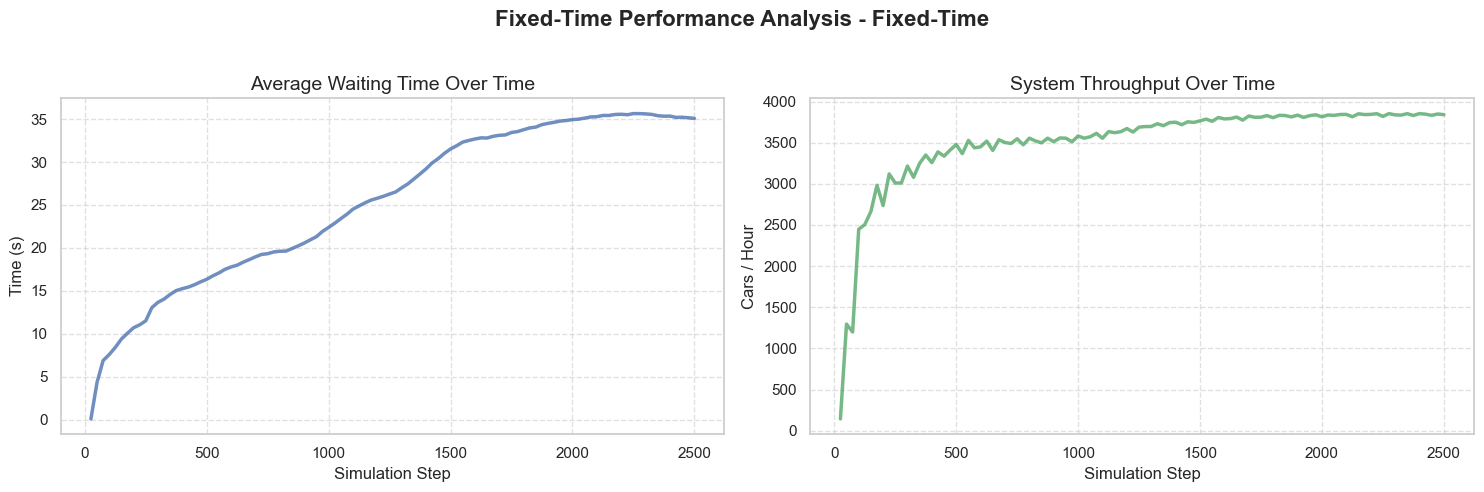


TRAFFIC CONTROLLER PERFORMANCE ANALYSIS - Q-Learning
Controller Type: Q-Learning
Scenario: Morning commute pattern

--- Final Simulation Statistics ---
  Average Waiting Time: 20.22 s
  System Throughput: 1.045 cars/s (3762.7 cars/hr)
  Vehicle Completion Rate: 97.54%
  Total Reward Accumulated: 458.4
  Q-Table Size (Learned States): 14
  Final Exploration Rate (Epsilon): 0.0540


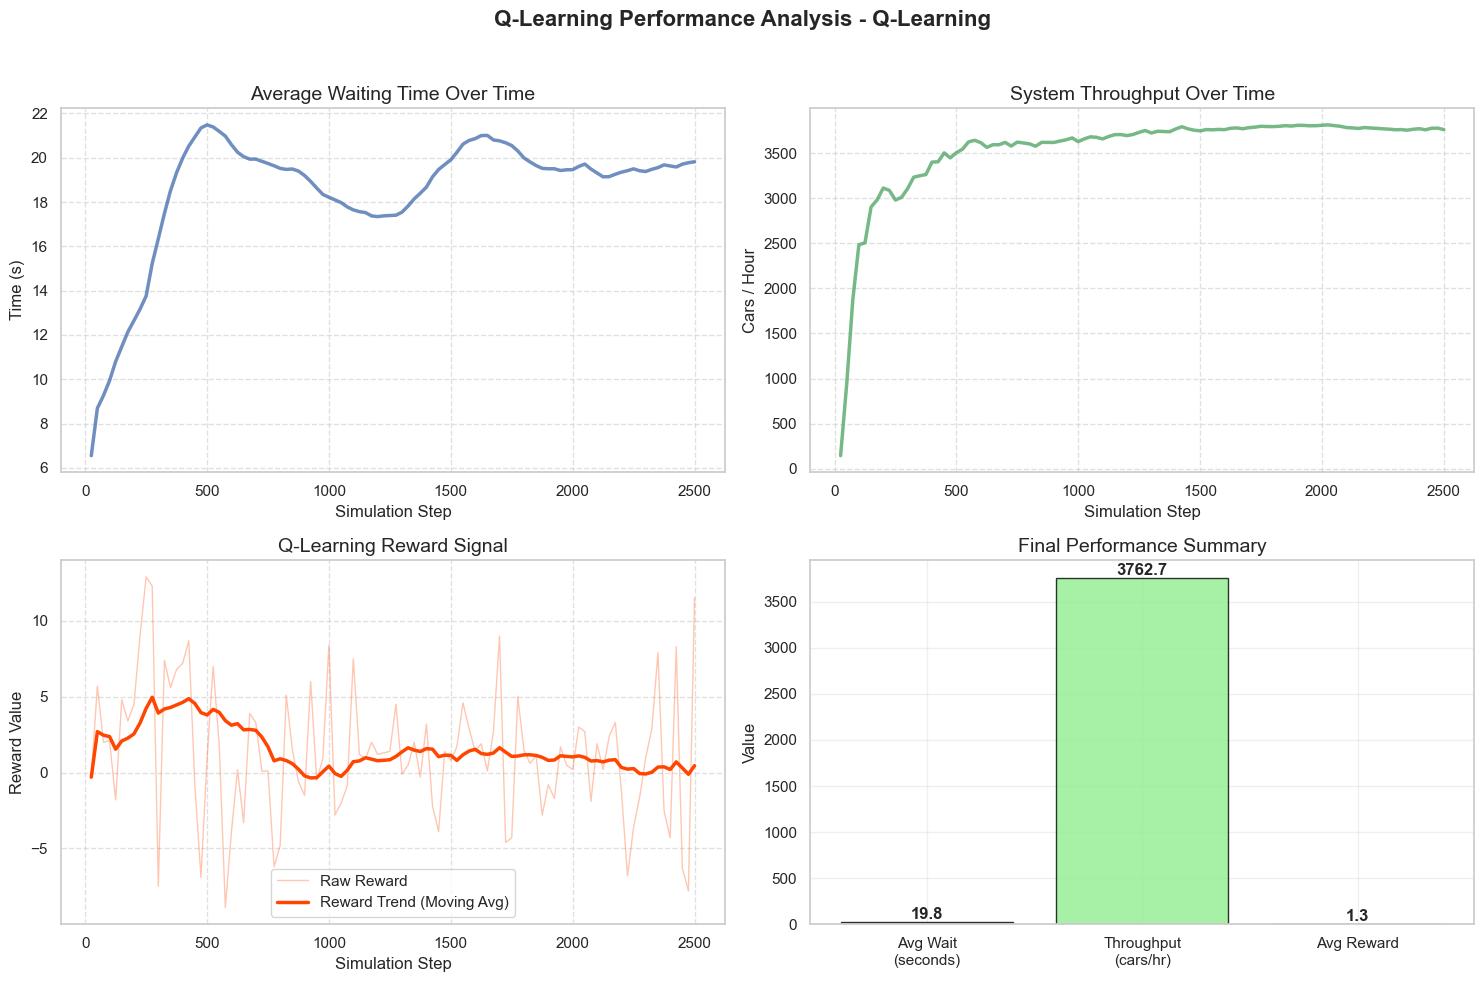


Generating comparison plots...


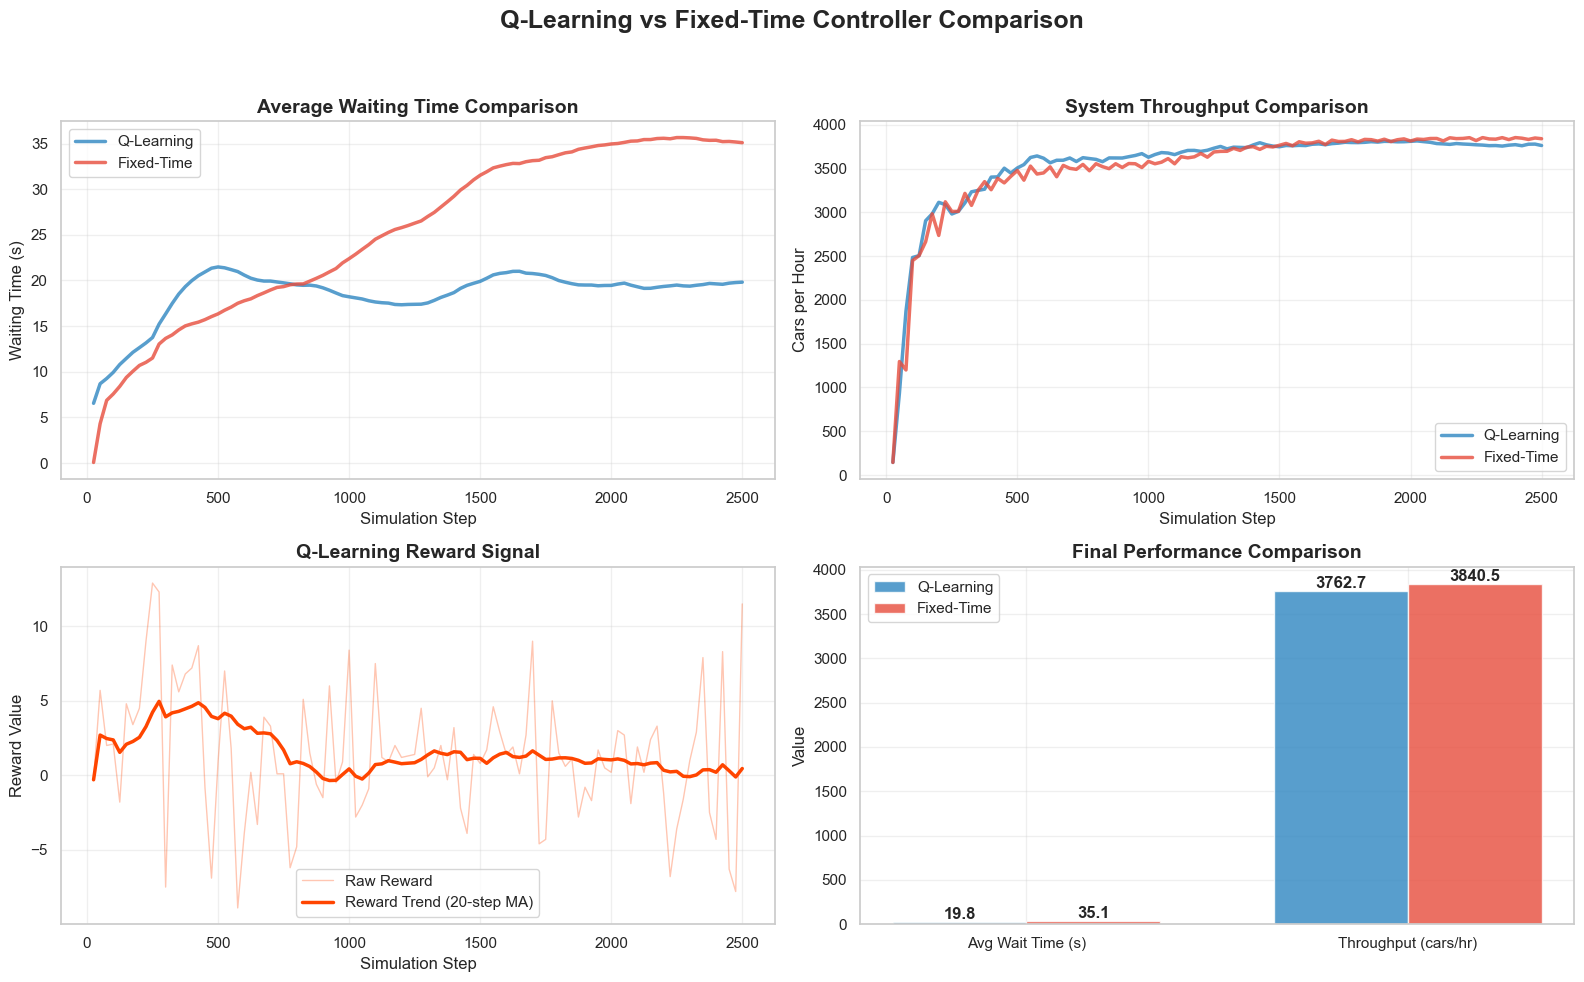


✓ Comparison study completed successfully!


In [673]:
models,results = run_enhanced_comparison_study(params, steps=2500)